In [1]:
import sys, os
import pandas as pd
import numpy as np

from IPython.display import display
pd.set_option('display.max_columns', None)

import site
site.addsitedir('/Applications/sam-sdk-2015-6-30-r3/languages/python/')
import PySAM.PySSC as pssc

In [2]:
import ipywidgets as widgets

def createStateOptionsWidget():
    # Formatting settings for drop-down menus
    style = {'description_width': '120px'}
    layout = widgets.Layout(width='325px')
    
    global state_info
    state_info = pd.read_json('USstates_avg_latLong.json')

    # Create drop-down menu for states option
    return widgets.Dropdown(options = state_info.state.tolist(), 
                            description = 'States:', style=style, layout=layout)

In [3]:
def solar_power_simulation(state, year):
    # data generation
    lat = state_info[state_info['state'] == statechoice.value]['latitude'].values[0]
    lon = state_info[state_info['state'] == statechoice.value]['longitude'].values[0]
    api_key = '2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU'
    attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'
    year = year
    leap_year = 'false'
    interval = '30'
    utc = 'false'
    your_name = 'Justin+Lin'
    reason_for_use = 'beta+testing'
    your_affiliation = 'HTF'
    your_email = 'slin@wvhtf.org'
    mailing_list = 'false'
    
    url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'\
    .format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    
    info = pd.read_csv(url, nrows=1)
    timezone, elevation = info['Local Time Zone'], info['Elevation']
    
    df = pd.read_csv(url, skiprows=2)
    df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

    # SAM Model for solar simulation
    ssc = pssc.PySSC()
    
    # Resource inputs for SAM model:
    # Must be byte strings
    wfd = ssc.data_create()
    ssc.data_set_number(wfd, b'lat', lat)
    ssc.data_set_number(wfd, b'lon', lon)
    ssc.data_set_number(wfd, b'tz', timezone)
    ssc.data_set_number(wfd, b'elev', elevation)
    ssc.data_set_array(wfd, b'year', df.index.year)
    ssc.data_set_array(wfd, b'month', df.index.month)
    ssc.data_set_array(wfd, b'day', df.index.day)
    ssc.data_set_array(wfd, b'hour', df.index.hour)
    ssc.data_set_array(wfd, b'minute', df.index.minute)
    ssc.data_set_array(wfd, b'dn', df['DNI'])
    ssc.data_set_array(wfd, b'df', df['DHI'])
    ssc.data_set_array(wfd, b'wspd', df['Wind Speed'])
    ssc.data_set_array(wfd, b'tdry', df['Temperature'])
    
    # Create SAM compliant object  
    dat = ssc.data_create()
    ssc.data_set_table(dat, b'solar_resource_data', wfd)
    ssc.data_free(wfd)
    
    # Specify the system Configuration
    # Set system capacity in MW
    system_capacity = 4
    ssc.data_set_number(dat, b'system_capacity', system_capacity)
    # Set DC/AC ratio (or power ratio). See https://sam.nrel.gov/sites/default/files/content/virtual_conf_july_2013/07-sam-virtual-conference-2013-woodcock.pdf
    ssc.data_set_number(dat, b'dc_ac_ratio', 1.1)
    # Set tilt of system in degrees
    ssc.data_set_number(dat, b'tilt', 25)
    # Set azimuth angle (in degrees) from north (0 degrees)
    ssc.data_set_number(dat, b'azimuth', 180)
    # Set the inverter efficency
    ssc.data_set_number(dat, b'inv_eff', 96)
    # Set the system losses, in percent
    ssc.data_set_number(dat, b'losses', 14.0757)
    # Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
    ssc.data_set_number(dat, b'array_type', 0)
    # Set ground coverage ratio
    ssc.data_set_number(dat, b'gcr', 0.4)
    # Set constant loss adjustment
    ssc.data_set_number(dat, b'adjust:constant', 0)
    
    # execute and put generation results back into dataframe
    mod = ssc.module_create(b'pvwattsv5')
    ssc.module_exec(mod, dat)
    df[b'generation'] = np.array(ssc.data_get_array(dat, b'gen'))
    
    # free the memory
    ssc.data_free(dat)
    ssc.module_free(mod)
    
    return df

In [4]:
from matplotlib import pyplot as plt

def daily_plot(df, i):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df['90 Degree Zenith'] = 90
    df[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle', '90 Degree Zenith']][i:i+30].plot(ax=ax, figsize=(15,8), yticks=(np.arange(0,900,100)), style={'90 Degree Zenith': '--','Solar Zenith Angle': '-o', 'DNI': '-o', 'DHI': '-o', 'GHI': '-o'}, legend=False)
    df[b'generation'][i:i+30].plot(ax=ax2, yticks=(np.arange(0,4.5,0.5)), style={'generation': 'y-o'})
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)

In [5]:
def month_plot(df):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df = df.groupby('Month').sum()[['GHI', b'generation']]
    df['GHI'].plot(ax=ax, figsize=(15,8), color = 'r', legend=False)
    df[b'generation'].plot(ax=ax2, color = 'b')
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)

In [6]:
def year_plot(df):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df = df.groupby('Year').sum()[['GHI', b'generation']]
    df['GHI'].plot(ax=ax, figsize=(15,8), color = 'r', legend=False)
    df[b'generation'].plot(ax=ax2, color = 'b')
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks(df.index)

In [7]:
statechoice = createStateOptionsWidget()
statechoice

Dropdown(description='States:', layout=Layout(width='325px'), options=('Alaska', 'Alabama', 'Arkansas', 'Arizo…

In [17]:
appended_data = []
for year in range(2015, 2018):
    appended_data.append(solar_power_simulation(statechoice.value, year))

df = pd.concat(appended_data)
df

C:\Users\slin\Anaconda3\envs\testenv\Lib\site-packages\PySAM\PySSC.py:174: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.pdll.ssc_data_set_number(c_void_p(p_data), c_char_p(name), c_number(value))
C:\Users\slin\Anaconda3\envs\testenv\Lib\site-packages\PySAM\PySSC.py:180: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arr[:] = parr  # set all at once instead of looping
C:\Users\slin\Anaconda3\envs\testenv\Lib\site-packages\PySAM\PySSC.py:174: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.pdll.ssc_data_set_number(c_void_p(p_data), c_char_p(name), c_number(value))
C:\Users\slin\Anaconda3\envs\testenv\

,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle,b'generation'
2015-01-01 00:00:00,2015,1,1,0,0,0,0,0,2.4,15,171.66,0.0
2015-01-01 00:30:00,2015,1,1,0,30,0,0,0,2.2,15,175.17,0.0
2015-01-01 01:00:00,2015,1,1,1,0,0,0,0,2.1,15,171.70,0.0
2015-01-01 01:30:00,2015,1,1,1,30,0,0,0,2.0,15,165.66,0.0
2015-01-01 02:00:00,2015,1,1,2,0,0,0,0,1.9,15,159.17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,2017,12,31,21,30,0,0,0,0.7,15,139.22,0.0
2017-12-31 22:00:00,2017,12,31,22,0,0,0,0,0.8,15,145.84,0.0
2017-12-31 22:30:00,2017,12,31,22,30,0,0,0,0.8,14,152.47,0.0
2017-12-31 23:00:00,2017,12,31,23,0,0,0,0,0.9,14,159.06,0.0


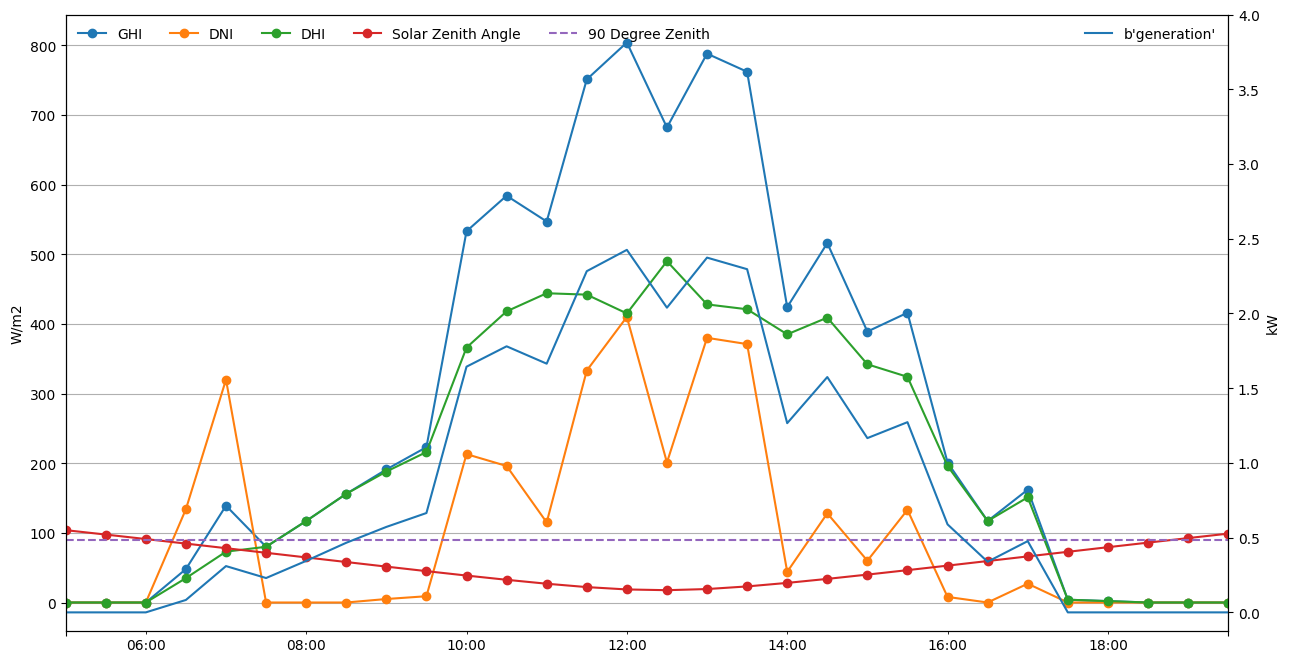

In [18]:
daily_plot(df, 5050)

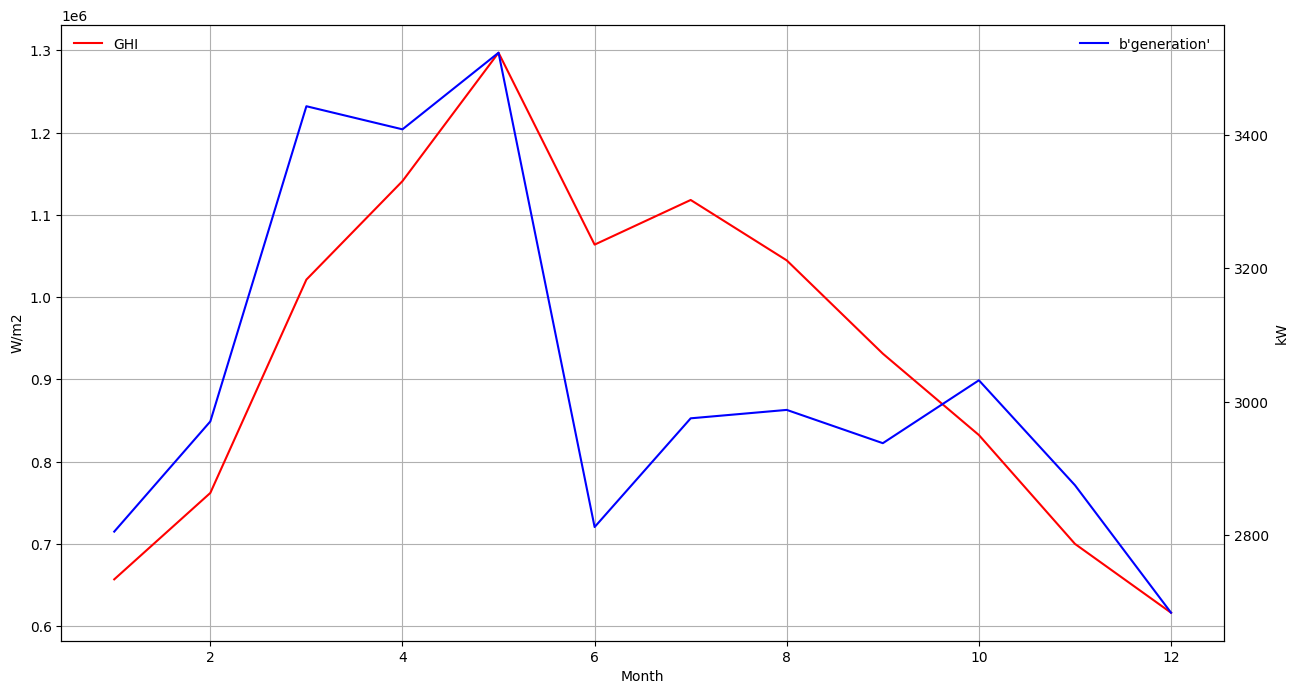

In [19]:
month_plot(df)

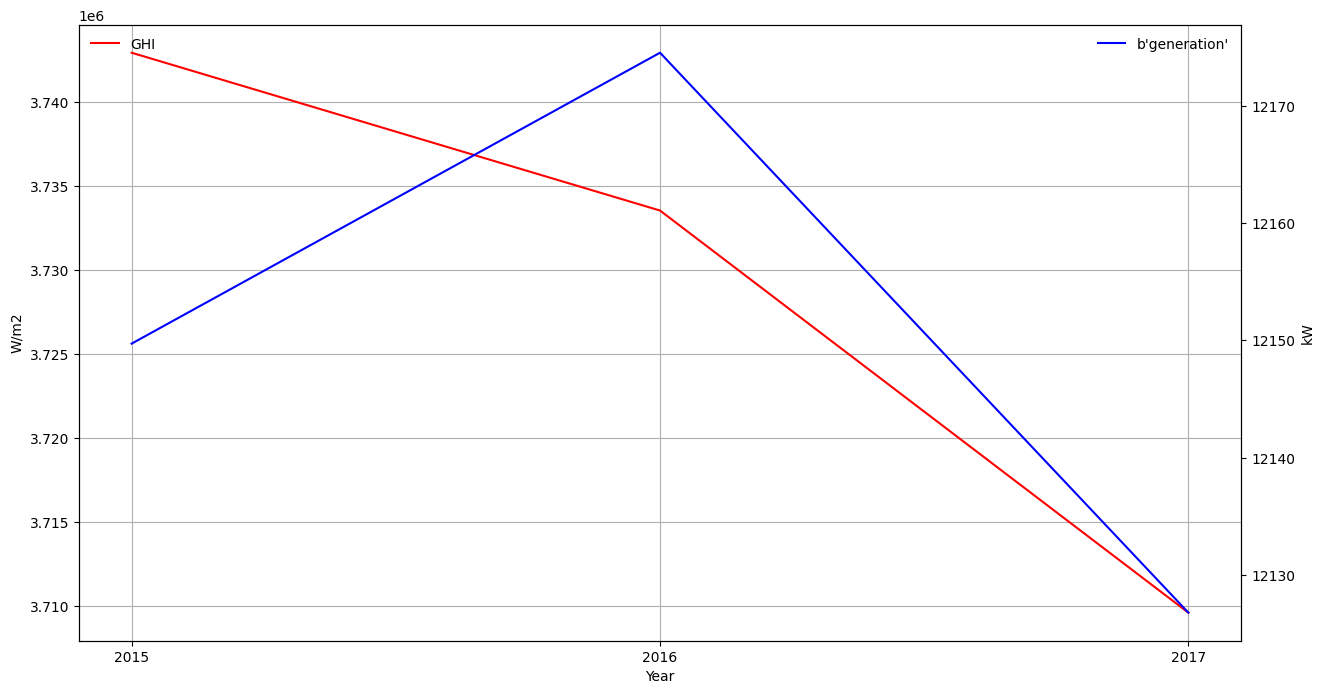

In [20]:
year_plot(df)